![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k    
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, MSE=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)
print(tree)


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


predicciones=tree_predict(X_test, tree)


predicciones1=predicciones.tolist()
y_test1=y_test.tolist()
tp=0
tn=0
fp=0
fn=0
i=0
listi=[]
while i < len(predicciones1):
    if predicciones1[i]==1:
        if y_test1[i]==1:
            tp=tp+1
        else:
            fp=fp+1
    else:
        if y_test1[i]==0:
            tn=tn+1
        else:
            fn=fn+1
    i=i+1
    
    
print('-------------------Análisis de Accuracy-------------------')
accuracy_tree=(tp+tn)/(tp+tn+fp+fn)
print('verdaderos positivos: '+str(tp))
print('verdaderos negativos: '+str(tn))
print('falsos positivos: '+str(fp))
print('falsos negativos: '+str(fn))
print(accuracy_tree)

{'y_pred': 1, 'y_prob': 0.5778472913408218, 'level': 0, 'split': [1, 51394.909090909096], 'n_samples': 7031, 'gain': 0.23630504821132137, 'sl': {'y_pred': 1, 'y_prob': 0.8375781948168007, 'level': 1, 'split': [0, 2015.0], 'n_samples': 4474, 'gain': 0.03713896892744761, 'sl': {'y_pred': 1, 'y_prob': 0.6404416839199448, 'level': 2, 'split': [0, 2013.0], 'n_samples': 1447, 'gain': 0.043426293133466354, 'sl': {'y_pred': 0, 'y_prob': 0.2780487804878049, 'level': 3, 'split': [0, 2012.0], 'n_samples': 203, 'gain': 0.05394731382546758, 'sl': {'y_pred': 0, 'y_prob': 0.09195402298850575, 'level': 4, 'split': [1, 35652.36363636363], 'n_samples': 85, 'gain': 0.01352946029496721, 'sl': {'y_pred': 0, 'y_prob': 0.24, 'level': 5, 'split': -1, 'n_samples': 23, 'gain': 0.08132745221592097}, 'sr': {'y_pred': 0, 'y_prob': 0.046875, 'level': 5, 'split': -1, 'n_samples': 62, 'gain': 0.0038712154997273124}}, 'sr': {'y_pred': 0, 'y_prob': 0.4166666666666667, 'level': 4, 'split': [1, 24887.363636363636], 'n_sa

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

n_estimators = 10 #Número de árboles y muestras bootstrap

np.random.seed(123)
n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_estimators +1 )]

# Para que los arboles sean diferentes generamos semillas diferentes
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_estimators))])

# Entrenamiento de 10 modelos con las 10 muestras boostrap
for i, sample in enumerate(samples):
    tree = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    tree.fit(X_train.iloc[sample],  y_train.iloc[sample])
    y_pred.iloc[:,i] = tree.predict(X_test)

# Desempeño de cada árbol
for i in range(n_estimators):
    print('Árbol ', i, 'tiene un accuracy: ', accuracy_score(y_pred.iloc[:,i], y_test))
      
# Votación mayoritaria
y_pred_ = (y_pred.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
print('--------------------------------------')
accuracyBM = accuracy_score(y_test, y_pred_)
print('Accuracy = '+str(accuracyBM))

Árbol  0 tiene un accuracy:  0.8354503464203233
Árbol  1 tiene un accuracy:  0.8342956120092379
Árbol  2 tiene un accuracy:  0.8299653579676675
Árbol  3 tiene un accuracy:  0.8386258660508084
Árbol  4 tiene un accuracy:  0.8371824480369515
Árbol  5 tiene un accuracy:  0.8409353348729792
Árbol  6 tiene un accuracy:  0.8368937644341802
Árbol  7 tiene un accuracy:  0.8400692840646651
Árbol  8 tiene un accuracy:  0.8397806004618937
Árbol  9 tiene un accuracy:  0.8296766743648961
--------------------------------------
Accuracy = 0.851905311778291


> ### Resultados

> Para construir el baggind manueal se consideraron los siguientes puntos: 
> * Primero se obtuvieron 10 muestras "Bootstrap" y para cada una de ellas, se entreno en un árbol de decisión independiente y se hicieron las predicciones correspondientes. 
> * Al final se combinaron las predicciones de los diferentes árboles, y se seleccionó por votación mayoritaria el resultado debido a que tenemos un problema de clasificación. 
> * Cada muestra de "Bootstrap" se generó del mismo tamaño que el conjunto de entrenamiento original. 

> Bagging aumenta la precisión predictiva al reducir la varianza de manera similar cómo lo hace la validación cruzada. 

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [7]:
# Celda 3
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

n_estimators=10

bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth=None,max_features="log2"),
                            n_estimators=n_estimators,bootstrap=True, oob_score=True, random_state=1)

bagging.fit(X_train, y_train)
y_pred= bagging.predict(X_test)


print(y_pred)
print("Accuracy: " + str(metrics.accuracy_score(y_test, y_pred)))

[0 0 1 ... 1 0 0]
Accuracy: 0.8429561200923787


> ### Resultados
> Se puede observar que la métrica de Accuracy nos arroja un mejor/peor resultado que el árbol de decisión, pues mientras el primero nos arroja una métrica de 0.887 , el bagging nos arroja 0.842

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [8]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp  = confusion_matrix(y_test,y_pred).ravel()
print('True Positives (TP) = ' + str(tp) + '\tTrue Negatives (TN) = ' + str(tn) + '\tNúmero total de muestras (n) = ' + str(X_test.shape[0]))

accuracyRF = accuracy_score(y_test, y_pred)
f1RF = f1_score(y_test, y_pred)
print('Accuracy = '+str(accuracyRF))
print('F1 = '+str(f1RF))

True Positives (TP) = 1762	True Negatives (TN) = 1163	Número total de muestras (n) = 3464
Accuracy = 0.8443995381062356
F1 = 0.8673394043809993


> ### Resultados

> El modelo Random Forest se entrenó con los parametros por default, que en este caso son: 
> * n_estimators (número de árboles) = 100
> * criterion (función para estimar las divisiones) = gini
> * max_depth (profundidad máxima del ábol) = None, es decir, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos de min_samples_split.
> * min_samples_split (número mínimo de muestras requeridas para dividir un nodo interno) = 2 
> * max_features (número de variables que se deben considerar en cada árbol) = auto, es decir, se incluyen todas.

> Al realizar el calculo del accuray con la muestra de Test se obtuvo un resultado de 0.84, es decir, el modelo acierta el 84% de las veces. Es importante recordar que el accuracy es una métrica para clasificación y esta es la razón por la cuál podemos utilizarla en este ejercicio



### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

Accuracy = 0.8911662817551963
F1 = 0.9106846718787017


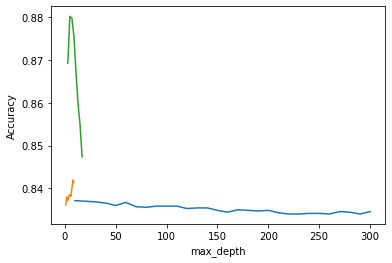

In [9]:
# Celda 5
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_cols = X_train.columns
feature_cols
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores1 = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=10, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores1.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores1)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
estimator_range1 = range(3, 18, 2)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores2 = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in estimator_range1:
    clf = RandomForestClassifier(n_estimators=10, max_depth=max_depth, max_features=8, random_state=1, n_jobs=-1)
    accuracy_scores2.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    
    
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(estimator_range1, accuracy_scores2)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Definición del modelo con los parámetros max_features=8, max_depth=5 y n_estimators=10 
clf1 = RandomForestClassifier(n_estimators=10, max_depth=5, max_features=8, random_state=1, n_jobs=-1)
clf1.fit(X_test, y_test)
y_predRFC= clf1.predict(X_test)
accuracyRFC = accuracy_score(y_test, y_predRFC)
f1RFC = f1_score(y_test, y_predRFC)
print('Accuracy = '+str(accuracyRFC))
print('F1 = '+str(f1RFC))

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [10]:
# Celda 6
# Importación y definición de modelo XGBClassifier

!pip install xgboost
from sklearn import metrics
from xgboost import XGBClassifier

clf = XGBClassifier()

# Entrenamiento (fit) y desempeño del modelo XGBClassifier

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracyXGB = metrics.accuracy_score(y_pred, y_test.values)
f1XGB = metrics.f1_score(y_pred, y_test.values)
print('F1 score: '+ str(f1XGB))
print('Accuracy: '+ str(accuracyXGB))


[10:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score: 0.9047160731472569
Accuracy: 0.8856812933025404


> ### Resultados 
> El valor conseguido para el f1_score fue de 0.9047 con un accuracy de 0.8856, es decir un 88,56% de los datos fueron clasificados correctamente.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [11]:
# Celda 7
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
# Calibrar el parametro gamma

# Por medio de GridSearchCV se buscara el valor para el parametro gamma que nos arroje mejores resultados dentro de los valores
# tipicos que se manejan. GridSearch nos ayuda a iterar con los valores especificados para obtener la
# mayor precisión

# Se define el rango de los valores tipicos que utiliza el parametro gamma
param_gamma = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# Por medio de GridSearchCV se recorreran todas las combinaciones posibles establecidas anteriormente para poder
# encontrar la que mayor precisión nos ofrece
gsearch_1 = GridSearchCV(estimator = XGBClassifier(eval_metric='error'), 
 param_grid = param_gamma, cv=5)

# Se procede a entrenar el modelo
gsearch_1.fit(X_train, y_train)

print('Mejor parametro gamma con el debido resultado')
best_gamma=gsearch_1.best_params_['gamma']
print(gsearch_1.best_params_), print(gsearch_1.best_score_)


# Calibrar el parametro learning_rate

# Se define el rango de los valores tipicos que utiliza el parametro learning_rate
param_learning_rate = {
 'learning_rate' : [0.001, 0.01, 0.1]
}

# Por medio de GridSearchCV se recorreran todas las combinaciones posibles establecidas anteriormente para poder
# encontrar la que mayor precisión nos ofrece
gsearch_2 = GridSearchCV(estimator = XGBClassifier(gamma=best_gamma, eval_metric='error'), 
 param_grid = param_learning_rate, cv=5)

# Se procede a entrenar el modelo
gsearch_2.fit(X_train, y_train)

print('Mejor parametro learning_rate con el debido resultado')
best_learning_rate=gsearch_2.best_params_['learning_rate']
print(gsearch_2.best_params_), print(gsearch_2.best_score_)


# Calibrar el parametro colsample_bytree

# Se define el rango de los valores tipicos que utiliza el parametro best_learning_rate
param_colsample_bytree = {
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# Por medio de GridSearchCV se recorreran todas las combinaciones posibles establecidas anteriormente para poder
# encontrar la que mayor precisión nos ofrece
gsearch_3 = GridSearchCV(estimator = XGBClassifier(gamma=best_gamma, learning_rate=best_learning_rate, eval_metric='error'), 
 param_grid = param_colsample_bytree, cv=5)

# Se procede a entrenar el modelo
gsearch_3.fit(X_train, y_train)

print('Mejor parametro colsample_bytree con el debido resultado')
best_colsample_bytree=gsearch_3.best_params_['colsample_bytree']
print(gsearch_3.best_params_), print(gsearch_3.best_score_)


# Entrenamiento (fit) y desempeño del modelo XGBClassifier con los parametros obtenidos
clf = XGBClassifier(gamma=best_gamma, learning_rate=best_learning_rate,colsample_bytree=best_colsample_bytree,eval_metric='error')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



accuracyXGBC = metrics.accuracy_score(y_pred, y_test.values)
f1XGBC = metrics.f1_score(y_pred, y_test.values)

print('Resultado con los mejores parametros:')
print('F1 score: '+str(f1XGBC)), print('Accuracy: '+str(accuracyXGBC))

Mejor parametro gamma con el debido resultado
{'gamma': 0.0}
0.8742719040440956
Mejor parametro learning_rate con el debido resultado
{'learning_rate': 0.01}
0.8796768039501739
Mejor parametro colsample_bytree con el debido resultado
{'colsample_bytree': 0.7}
0.8812413243677973
Resultado con los mejores parametros:
F1 score: 0.9073588949749941
Accuracy: 0.8877020785219399


(None, None)

> ### Resultados
> Mientras se iban calibrando los parametros se pudo observar como mejoraban los resultados, al utilizar los 3 parametros finales se obtuvo un accuracy de 0,8877 con el cual se mejoraron los resultados obtenidos en el punto 6.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

-------------------------------- Comparación de Modelos por Accuracy --------------------------------------


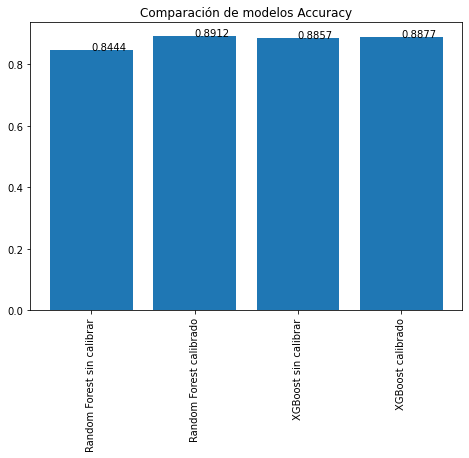

-------------------------------- Comparación de Modelos por F1 --------------------------------------


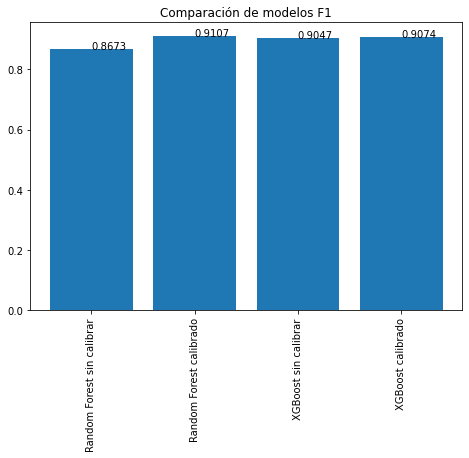

In [12]:
# Celda 8
#Comparacion de modelos
print('-------------------------------- Comparación de Modelos por Accuracy --------------------------------------')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos Accuracy")
ejeX = ['Random Forest sin calibrar','Random Forest calibrado','XGBoost sin calibrar','XGBoost calibrado']
ejeY = [round(accuracyRF,4),round(accuracyRFC,4),round(accuracyXGB,4),round(accuracyXGBC,4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()

print('-------------------------------- Comparación de Modelos por F1 --------------------------------------')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos F1")
ejeX = ['Random Forest sin calibrar','Random Forest calibrado','XGBoost sin calibrar','XGBoost calibrado']
ejeY = [round(f1RF,4),round(f1RFC,4),round(f1XGB,4),round(f1XGBC,4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()



> ### Resultados 
> Gracias a las graficas anteriores podemos observar que para ambas metricas (accuracy y F1), el valor de los modelos cablibrado es mejor. En el caso de Random Forest la diferencia es significativa y para XGBoost es pequeña pero sigue mostrando mejora el modelo calibrado